In [24]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
np.random.seed(24)

In [3]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

# Accuracy

Accuracy = Total number of correct predictions / total number of predictions -> Percentage of correct predictions.

For binary classification, this translate to Accuracy = TP + TN = TP+TN+FP+FN.

This is not an approriate metric for imbalance dataset due to the fact that it doesn't take into consideration the number of correctly classified examples of different classes (the minority class has very low impact on the overall accuracy).

Baseline detection = Predict always the majority class.

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
df = load_data()

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,0
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,0
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,0
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,0
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,0


In [7]:
df.shape

(145751, 75)

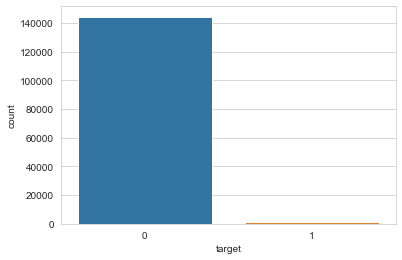

In [8]:
sns.countplot(x="target", data=df)
plt.show()

In [9]:
df["target"].value_counts(normalize=True) * 100

0    99.110812
1     0.889188
Name: target, dtype: float64

**Baseline model** : 99.11%

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [11]:
X_train.shape,X_test.shape

((97653, 74), (48098, 74))

In [12]:
y_train_base = pd.Series(np.zeros(len(y_train)))
y_test_base = pd.Series(np.zeros(len(y_test)))

## Training some ML Models

In [13]:
rf = RandomForestClassifier(n_jobs=-1, random_state=24, n_estimators=10)

rf.fit(X_train, y_train)

y_train_rf = rf.predict_proba(X_train)[:, 1]
y_test_rf = rf.predict_proba(X_test)[:, 1]

In [79]:
sgd = SGDClassifier(random_state=24, max_iter=1000, loss="log")

sgd.fit(X_train, y_train)

y_train_sgd = sgd.predict_proba(X_train)[:, 1]
y_test_sgd = sgd.predict_proba(X_test)[:, 1]

In [27]:
print(f"Accuracy baseline: {accuracy_score(y_test,y_test_base)}")
print(f"Accuracy SGDClassifier: {accuracy_score(y_test,sgd.predict(X_test))}")
print(f"Accuracy RandomForest: {accuracy_score(y_test,rf.predict(X_test))}")

Accuracy baseline: 0.9912886190694
Accuracy SGDClassifier: 0.9957586594037174
Accuracy RandomForest: 0.9972971849141337


Super high accuracy but...

In [16]:
def minority_perc(y_pred,y_true):
    return np.mean(np.where((y_pred == 1) & (y_true ==1),1,0)) * 100

In [28]:
print(f"Minority class correclty classified baseline: {minority_perc(y_test,y_test_base)}")
print(f"Minority class correclty classified SGDClassifier: {minority_perc(y_test,y_test_sgd)}")
print(f"Minority class correclty classified RandomForest: {minority_perc(y_test,y_test_rf)}")

Minority class correclty classified baseline: 0.0
Minority class correclty classified SGDClassifier: 0.6029356730009564
Minority class correclty classified RandomForest: 0.4220549711006695


... but only 42% of the observation in the minority class have been correctly classified.

# Precision, Recall and F-Measure

* True Positive Rate (Recall / sensitivity): TP(rate) = TP / TP+FN **- Minority Class**
* True Negative Rate: TN(rate): TN(rate) = TN / TN + FP **- Majority Class**
* Positive Predicted Value (Precision/specificity): PP(value) = TP / TP+FP **- Minority Class**
* Negative Predicted Value: NP(value) = TN / TN+FN **- Majority Class**

The best is to maximize both precision and recall, but sometimes it is not possible, so we have to tune the threshold we use to determine to which class belongs to the observation.

F1-Score (F-Measure) = 2 x (Precision x Recall) / (Precision + Recall)

This is the weight harmonic mean of the precision and the recall. Optimizing this metric produces the best balance between the precision and the recall.

Support refers to the actual number of occurences of a class in the dataset. It allows to highlight imbalanced datasets.

In [20]:
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            )

from yellowbrick.classifier import (ClassificationReport,
                                   DiscriminationThreshold)

## Precision

In [29]:
print(f"Precision baseline: {precision_score(y_test,y_test_base)}")
print(f"Precision SGDClassifier: {precision_score(y_test,sgd.predict(X_test))}")
print(f"Precision RandomForest: {precision_score(y_test,rf.predict(X_test))}")

Precision baseline: 0.0
Precision SGDClassifier: 0.7945205479452054
Precision RandomForest: 0.9800664451827242


/Users/alexandrecasula/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Recall

In [30]:
print(f"Recall baseline: {recall_score(y_test,y_test_base)}")
print(f"Recall SGDClassifier: {precision_score(y_test,sgd.predict(X_test))}")
print(f"Recall RandomForest: {recall_score(y_test,rf.predict(X_test))}")

Recall baseline: 0.0
Recall SGDClassifier: 0.7945205479452054
Recall RandomForest: 0.7040572792362768


## F1-Score

In [31]:
print(f"F1 Score baseline: {f1_score(y_test,y_test_base)}")
print(f"F1 Score SGDClassifier: {precision_score(y_test,sgd.predict(X_test))}")
print(f"F1 Score RandomForest: {f1_score(y_test,sgd.predict(X_test))}")

F1 Score baseline: 0.0
F1 Score SGDClassifier: 0.7945205479452054
F1 Score RandomForest: 0.7397959183673469


The LogisticRegession does a little bit better than the randomforest (with the default threshold at 0.5).

## Full classification report

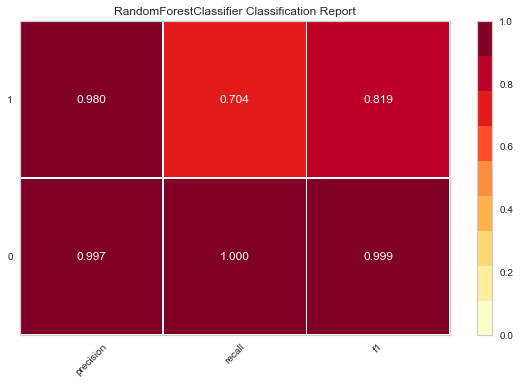

In [34]:
visualizer = ClassificationReport(rf)

visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

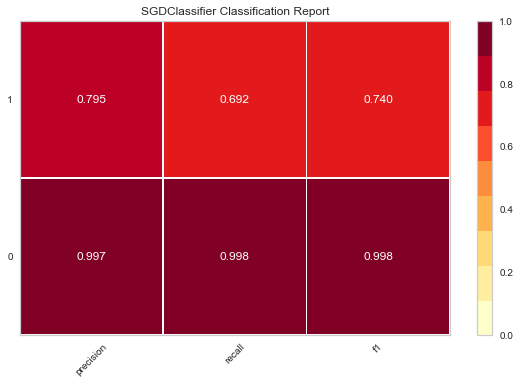

In [35]:
visualizer = ClassificationReport(sgd)

visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

/Users/alexandrecasula/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


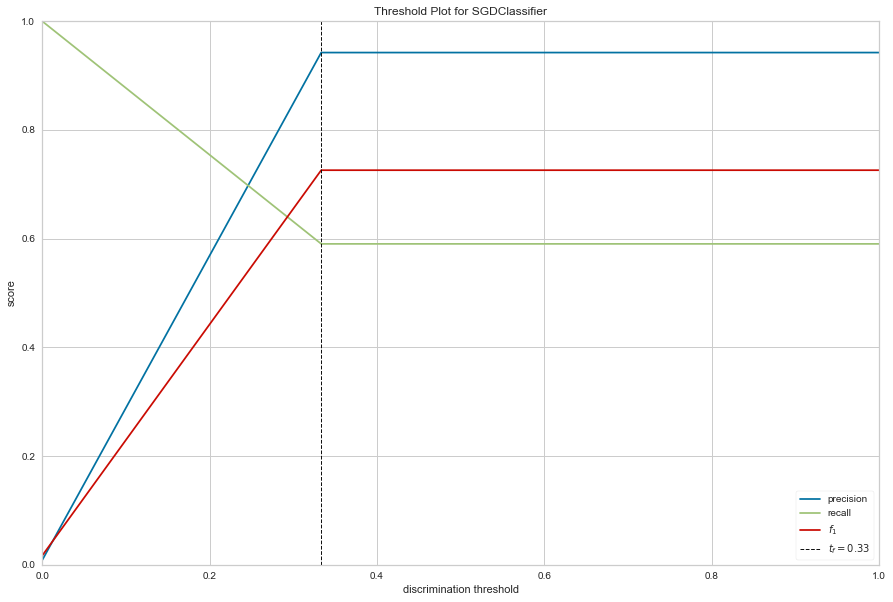

In [49]:
visualizer = DiscriminationThreshold(sgd,
                                     n_trials=1,# 1 to speed up process but can be higher to reduce the error.
                                     cv=0.1,
                                     argmax='fscore',
                                     random_state=23,
                                     is_fitted='auto',
                                     exclude="queue_rate"
                                     )

plt.figure(figsize=(15,10))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

0.33 seems to be the perfect threshold in this case for optimizing the f1 score.

# Confusion matrix, FPR and FNP

A confusion matrix is a matrix of the instances that are correctly and incorrectly classified.
False Positive Rate: FP(rate) = FP / FP + TN --> How many observations from the majority class have been classified wrongly? (Type 2 Error)
False Negative Rate: FN(rate) = FN / FN + TP --> How many observations from the minority class have been classified wrongly? (Type 1 Error)

We try to minize both of them, and they all depend on the probability threshold.

Example:
* Minimize FPR: We want to minimize the number of people that are sick but are not diagnosed sick.
* Minimize FNR: We want to minimize the number of drugs that are predicted beneficial, but are not.

In [50]:
from sklearn.metrics import confusion_matrix

## Confusion Matrix

### Baseline

In [54]:
pd.DataFrame(confusion_matrix(y_test,y_test_base))

,0,1
0,47679,0
1,419,0


### Random Forest

In [56]:
pd.DataFrame(confusion_matrix(y_test,rf.predict(X_test)))

,0,1
0,47673,6
1,124,295


### LogisticRegression

In [58]:
pd.DataFrame(confusion_matrix(y_test,sgd.predict(X_test)))

,0,1
0,47604,75
1,129,290


## FPR and FNR

In [67]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_base,labels=[0,1]).ravel()

FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"FPR Baseline: {FPR}")
print(f"FNR Baseline: {FNR}")

FPR Baseline: 0.0
FNR Baseline: 1.0


FPR 0 because the model didn't identify any positive example as positive and the FNR is 1 because it classifies all the observations from the positive class incorrectly.

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test,rf.predict(X_test),labels=[0,1]).ravel()

FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"FPR Baseline: {FPR}")
print(f"FNR Baseline: {FNR}")

FPR Baseline: 0.00012584156546907444
FNR Baseline: 0.29594272076372313


In [69]:
tn, fp, fn, tp = confusion_matrix(y_test,sgd.predict(X_test),labels=[0,1]).ravel()

FPR = fp / (fp + tn)
FNR = fn / (fn + tp)

print(f"FPR Baseline: {FPR}")
print(f"FNR Baseline: {FNR}")

FPR Baseline: 0.0015730195683634305
FNR Baseline: 0.30787589498806683


## FPR and FNR vs Probability Threshold

In [70]:
thresholds = np.linspace(0,1,100)

In [71]:
thresholds

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [83]:
fpr_ls = []
fnr_ls = []

prob = sgd.predict_proba(X_test)[:, 1]

for threshold in thresholds:

    # Class from the threshold
    preds = np.where(prob >= threshold, 1, 0)

    tn, fp, fn, tp = confusion_matrix(y_test, preds, labels=[0, 1]).ravel()

    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)

    fpr_ls.append(FPR)
    fnr_ls.append(FNR)

metrics = pd.concat([pd.Series(fpr_ls), pd.Series(fnr_ls)], axis=1)

In [84]:
metrics.columns = ["fpr","fnr"]
metrics.index = thresholds

In [85]:
metrics.head()

,fpr,fnr
0.000000,1.000000,0.000000
0.010101,0.001615,0.307876
0.020202,0.001594,0.307876
0.030303,0.001594,0.307876
0.040404,0.001594,0.307876


<Figure size 864x720 with 0 Axes>

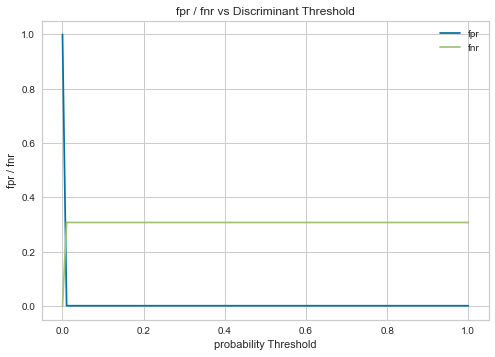

In [93]:
plt.figure(figsize=(12,10))
metrics.plot()
plt.xlabel("probability Threshold")
plt.ylabel("fpr / fnr")
plt.title("fpr / fnr vs Discriminant Threshold")
plt.show()

# Geometric Mean, Dominance, Index of Imbalance Accuracy

The Geometric Mean (G-Mean) tries to maximize the accuracy on each of the classes while keeping these accuracies balanced.

Worst score is 0 and best is 1.

G-Mean = sqrt(RECALL X TNR) = sqrt(sensitivity x specificity)

The dominance is TPR - TNR = Recall - TNR, and it measures between -1 and +1, where a value of +1 indicates a perfect accuracy on the minority class while all the cases from the majority class are misclassified. A value of -1 indicates that all the cases from the minority class (positive class) are misclassified while the cases from the majority class are correctly classified.

Index of Imbalance Accuracy tries to quantify a trade-off between an index of how balanced the accuracy of the classes are and a chosen unbias measure.
IBA(M) = (1+ alpha x dominance) x M
where the first part is a weighting factor and M represents any performance metric.

In [107]:
from sklearn.metrics import balanced_accuracy_score

from imblearn.metrics import geometric_mean_score as gmean, make_index_balanced_accuracy as iba

## True Negative Rate

Same as the recall but for the majority class.

In [97]:
print(f"Recall baseline: {recall_score(y_test,y_test_base,pos_label=0)}")
print(f"Recall SGDClassifier: {precision_score(y_test,sgd.predict(X_test),pos_label=0)}")
print(f"Recall RandomForest: {recall_score(y_test,rf.predict(X_test),pos_label=0)}")

Recall baseline: 1.0
Recall SGDClassifier: 0.9972974671610835
Recall RandomForest: 0.999874158434531


## G-Mean

G-Mean = sqrt(RECALL X TNR) = sqrt(sensitivity x specificity)

In [108]:
print(f"G-Mean baseline: {gmean(y_test,y_test_base)}")
print(f"G-Mean SGDClassifier: {gmean(y_test,sgd.predict(X_test))}")
print(f"G-Mean RandomForest: {gmean(y_test,rf.predict(X_test))}")

G-Mean baseline: 0.0
G-Mean SGDClassifier: 0.8312853783454954
G-Mean RandomForest: 0.8390284140397618


Baseline is zero because the recall is zero.

## Dominance

Dominance = TPR - TNR = Recall - TNR

In [105]:
def dominance(y_true,y_pred):
    
    TPR = recall_score(y_true,y_pred,pos_label=1)
    TNR = recall_score(y_true,y_pred,pos_label=0)
    
    return TPR - TNR

In [106]:
print(f"Dominance baseline: {dominance(y_test,y_test_base)}")
print(f"Dominance SGDClassifier: {dominance(y_test,sgd.predict(X_test))}")
print(f"Dominance RandomForest: {dominance(y_test,rf.predict(X_test))}")

Dominance baseline: -1.0
Dominance SGDClassifier: -0.30630287541970336
Dominance RandomForest: -0.29581687919825417


## Index Imbalance Accuracy

### Gmean

In [109]:
print(f"G-Mean baseline: {gmean(y_test,y_test_base)}")
print(f"G-Mean SGDClassifier: {gmean(y_test,sgd.predict(X_test))}")
print(f"G-Mean RandomForest: {gmean(y_test,rf.predict(X_test))}")

G-Mean baseline: 0.0
G-Mean SGDClassifier: 0.8312853783454954
G-Mean RandomForest: 0.8390284140397618


In [111]:
gmean = iba(alpha=0.5,squared=True)(gmean)

In [112]:
print(f"G-Mean baseline: {gmean(y_test,y_test_base)}")
print(f"G-Mean SGDClassifier: {gmean(y_test,sgd.predict(X_test))}")
print(f"G-Mean RandomForest: {gmean(y_test,rf.predict(X_test))}")

G-Mean baseline: 0.0
G-Mean SGDClassifier: 0.6910353802510135
G-Mean RandomForest: 0.703968679566078


### Accuracy

In [113]:
print(f"Accuracy baseline: {accuracy_score(y_test,y_test_base)}")
print(f"Accuracy SGDClassifier: {accuracy_score(y_test,sgd.predict(X_test))}")
print(f"Accuracy RandomForest: {accuracy_score(y_test,rf.predict(X_test))}")

Accuracy baseline: 0.9912886190694
Accuracy SGDClassifier: 0.9957586594037174
Accuracy RandomForest: 0.9972971849141337


In [114]:
accuracy = iba(alpha=0.5,squared=True)(accuracy_score)

In [115]:
print(f"Accuracy baseline: {accuracy(y_test,y_test_base)}")
print(f"Accuracy SGDClassifier: {accuracy(y_test,sgd.predict(X_test))}")
print(f"Accuracy RandomForest: {accuracy(y_test,rf.predict(X_test))}")

Accuracy baseline: 0.491326563148259
Accuracy SGDClassifier: 0.8396802498512859
Accuracy RandomForest: 0.847491693260158


Baseline is now 50% which corresponds to a situation where the classes are balanced. So we can really see that the two models are better than the baseline thanks to the adjusted accuracy.

## Balanced Accuracy Score

In [116]:
print(f"Accuracy baseline: {balanced_accuracy_score(y_test,y_test_base)}")
print(f"Accuracy SGDClassifier: {balanced_accuracy_score(y_test,sgd.predict(X_test))}")
print(f"Accuracy RandomForest: {balanced_accuracy_score(y_test,rf.predict(X_test))}")

Accuracy baseline: 0.5
Accuracy SGDClassifier: 0.8452755427217848
Accuracy RandomForest: 0.851965718835404


The balanced accuracy in binary and multiclass classification problems to
deal with imbalanced datasets. It is defined as the average of recall
obtained on each class.

The best value is 1 and the worst value is 0 when ``adjusted=False``.

# ROC-AUC

The ROC(Receiving Operating Characteristics) curve plots the TPrate (accuracy for the positive class) and the TNrate at different thresholds.

Each point of the curve represents a threshold and a trade-off between the two metrics.

It evaluates how well a model can separate the true positive and the true negative observations and helps choosing the best threshold.

Higher AUC indicates the model is better at predicting both classes.

The AUC (Area Under the Curve) provides an aggregate measures of performance accross all possible classification threshold. 

As the threshold decreases, the TPR increases (TP / TP+FP) and the FPR (TP / TP+FN) increases.

If the threshold = 0 then RECALL / TPR = 1 but FPR = balancing ration and if threshold = 1 then RECALL/TPR approx 0 and FRP approx 0.

The performance of our model will vary between ROC-AUC = 0.5 (random model) and ROC-AUC = 1. The closer to 1, the better is the model, with a perfect model having ROC-AUC = 1.

Issues: - Difficult to compare different models with discriminant thresholds as the behaviors of those models can be different.

In [118]:
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import  roc_auc_score,plot_roc_curve

## ROC-AUC

In [121]:
print(f"ROC-AUC baseline: {roc_auc_score(y_test,y_test_base)}")
print(f"ROC-AUC SGDClassifier: {roc_auc_score(y_test,sgd.predict_proba(X_test)[:,1])}")
print(f"ROC-AUC RandomForest: {roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])}")

ROC-AUC baseline: 0.5
ROC-AUC SGDClassifier: 0.8511026479237819
ROC-AUC RandomForest: 0.9245622863440227


## Plot ROC-AUC with Sklearn

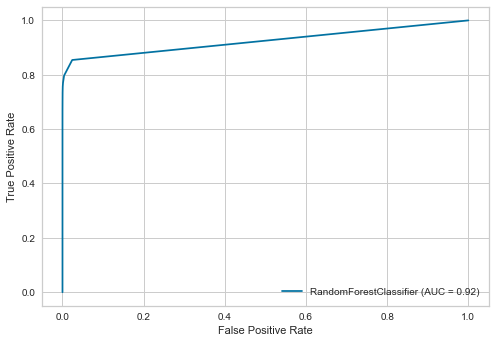

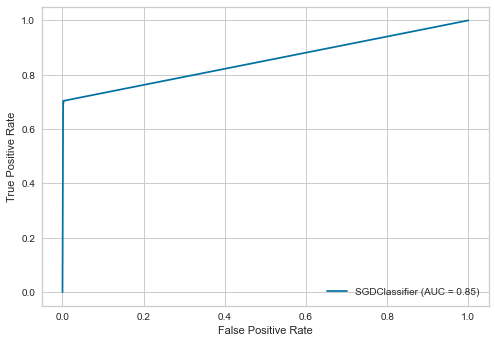

In [120]:
rf_dist = plot_roc_curve(rf,X_test,y_test)
sgd_dist = plot_roc_curve(sgd,X_test,y_test)

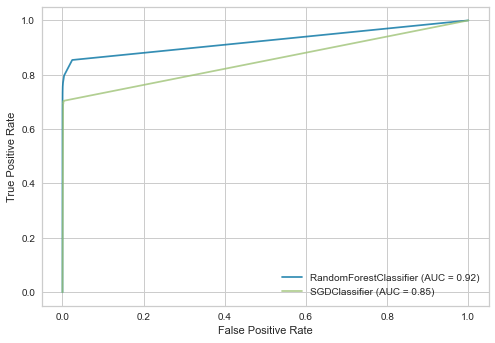

In [124]:
ax = plt.gca()
rf_dist.plot(ax=ax,alpha=0.8)
sgd_dist.plot(ax=ax,alpha=0.8)

## ROC-AUC with Yellowbrick

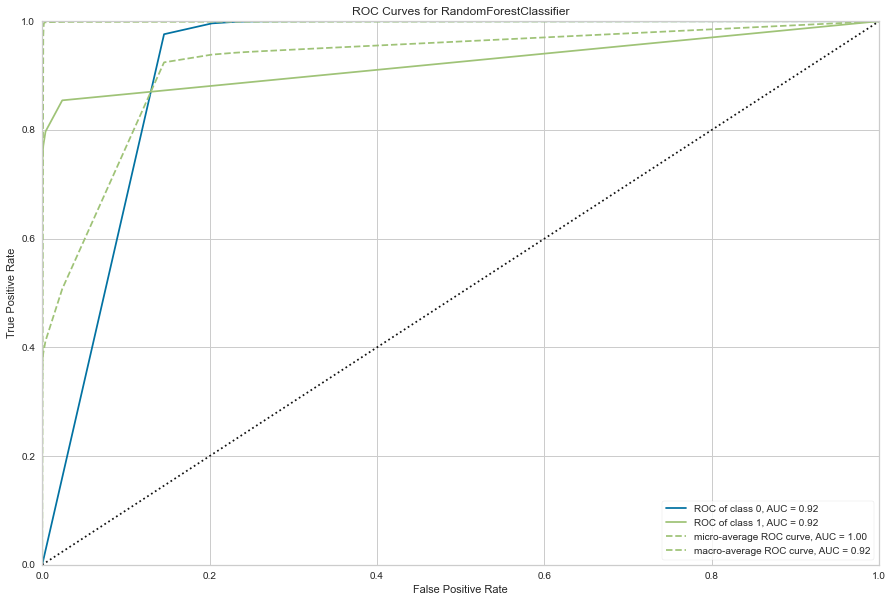

In [126]:
visualizer = ROCAUC(rf,classes=[0,1])

plt.figure(figsize=(15,10))
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

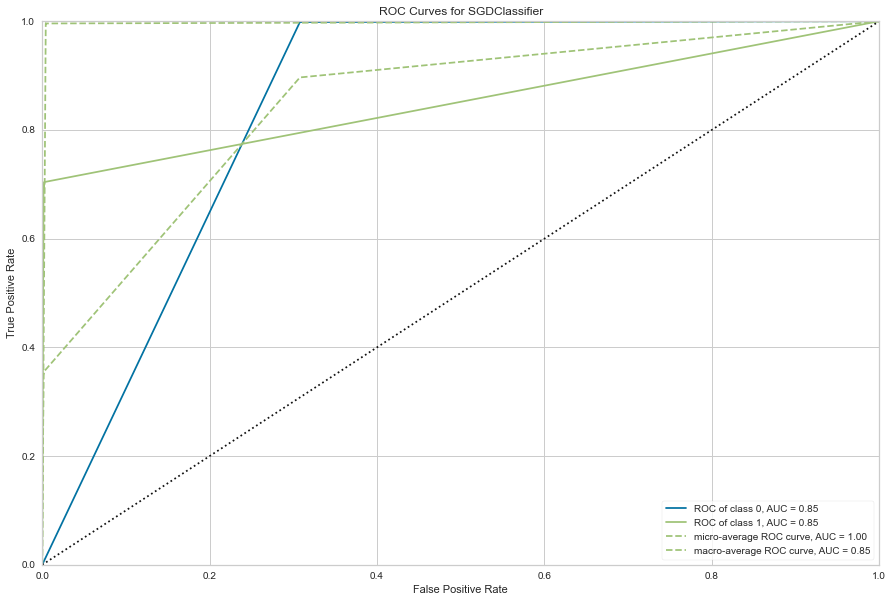

In [127]:
visualizer = ROCAUC(sgd,classes=[0,1])

plt.figure(figsize=(15,10))
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

# Precision-Recall Curve

Positive Predictive Value = TP / (TP+FP) = Precision

TPRate = TP / (TP + FN) = Recall / Sensitivity

Show the relationship between the precision and recall for every cut-off / discriminant probability threhold.

The area under the PRC provides an aggreate measure of the performance across all possible classification threhold. Higher area indicates better model.

The threshold decreases to the right of the plot (like the ROC-AUC), and when the threhold decreases, the precision 
(tp / tp+fp) decreases and the recall/sensitivity (tp / tp+fn) increases.

When the threshold approx 1, the recall approx 0 and precision approx 1.

PRC is more robust than ROC-AUC for imbalanced dataset because they are less sensitive to imbalance unlike ROC-AUC,which are sensitive to having many observations from the majority class which will make the ROC-AUC improve significantly. Therefore ROC-AUC reflects more the imbalanced than the true performance.

In [133]:
from sklearn.metrics import plot_precision_recall_curve

from yellowbrick.classifier import PrecisionRecallCurve

## Plot PRC Sklearn

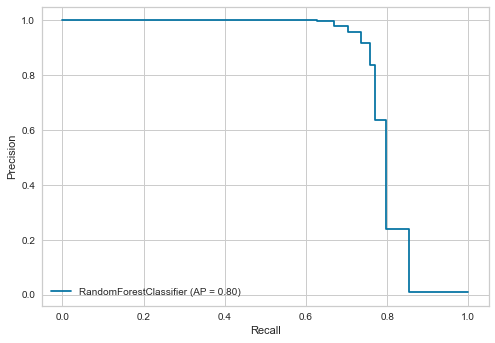

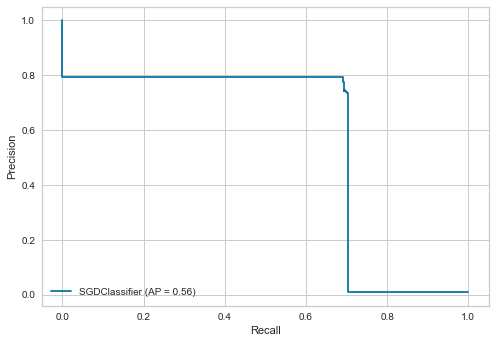

In [129]:
rf_dist = plot_precision_recall_curve(rf,X_test,y_test)
sgd_dist = plot_precision_recall_curve(sgd,X_test,y_test)

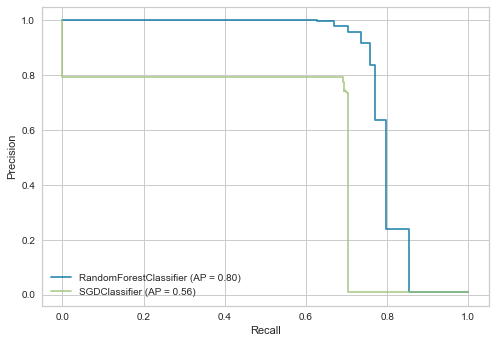

In [130]:
ax = plt.gca()
rf_dist.plot(ax=ax,alpha=0.8)
sgd_dist.plot(ax=ax,alpha=0.8)

## Plot with Yellowbrick

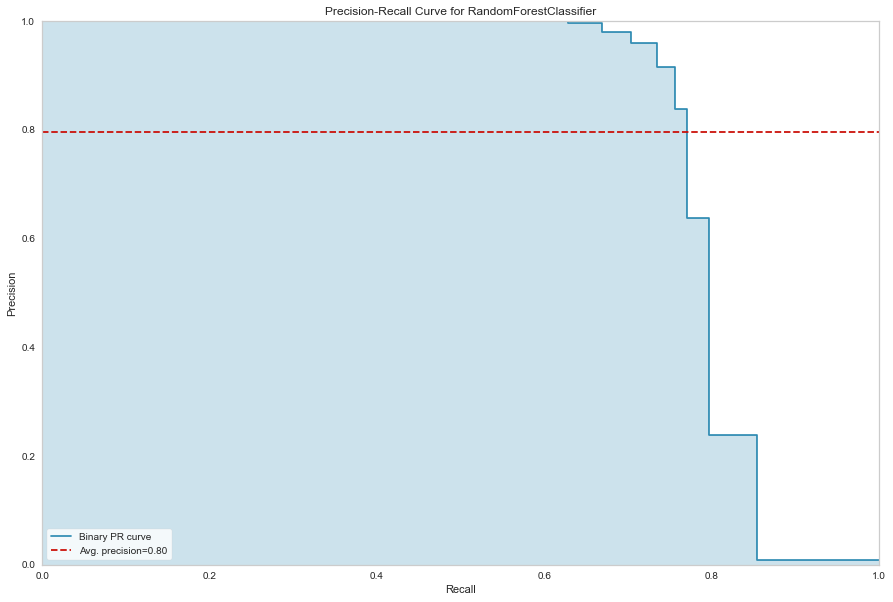

In [134]:
visualizer = PrecisionRecallCurve(rf,classes=[0,1])

plt.figure(figsize=(15,10))
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()

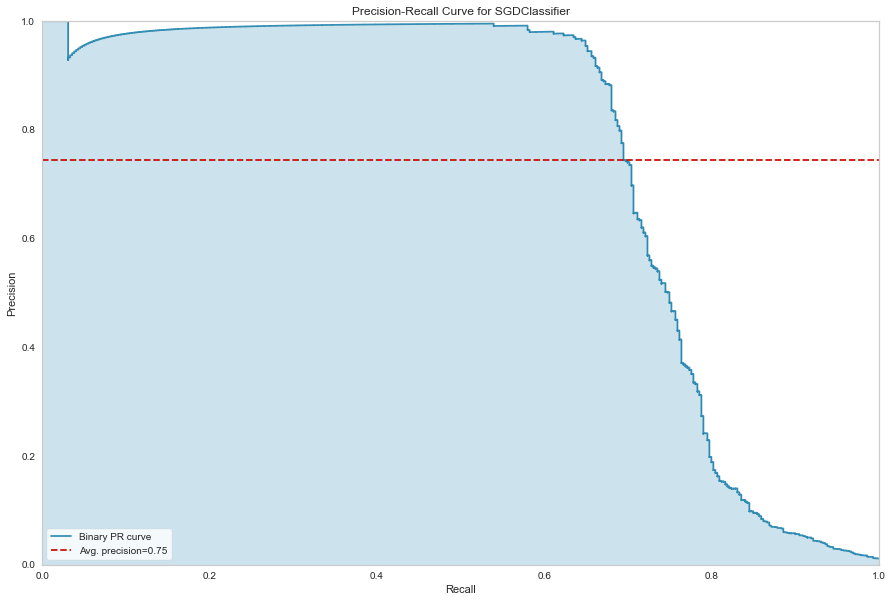

In [135]:
visualizer = PrecisionRecallCurve(sgd,classes=[0,1])

plt.figure(figsize=(15,10))
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.show()
plt.show()